### Proposal Report: Power Price Prediction

### Executive Summary 

Our proposed business solution aims to improve the accuracy of the power price prediction for Alberta province which is published by Alberta Electric System Operator(AESO) by developing a scalable machine learning product deployed on the cloud. This product will forecast the hourly energy price 12 hours in advance along with confidence intervals and will also address the lack of interepretibilty and explainability in the current system. This product will be accompanied by an intuitive tableau dashboard showcasing relevant visualizations to enable stakeholders to monitor real-time hourly predictions.

### Introduction
The electricity markets around the world have undergone a transformation from regulated to competitive and deregulated in the past few decades. Alberta's electricity market started deregulating in 1996, resulting in more volatile and uncertain power prices. This volatility makes accurate power price forecasting critical for businesses. In a deregulated market, the price series is more complex and volatile than the demand series. In Alberta's wholesale market for electricity, the price is determined through a uniform-price auction system. This project aims to forecast pool prices in a 12-hour-ahead window using the hourly published pool price.
This project has two key audiences. Firstly, it aims to broaden and deepen understanding of the subject through the technical products developed and the research study that supports it. Secondly, it aims to deliver tangible outcomes for potential clients of Slalom. Wholesale electricity consumers, traders, and generators can benefit from knowing the price ahead of time to increase efficiency in their decision-making. Government entities and regulators can also benefit from the project outcome as they monitor the market and enforce safe and reliable electricity supply.
The project intends to deliver three products: a model pipeline, a dashboard, and a report. The model pipeline will come with a confidence interval and all the scripts created for data cleaning, data wrangling, EDA, feature engineering, results, and evaluations. The dashboard will showcase real-time market price predictions and selected facts and informative data visualizations in a reactive and interactive way. The report will document studies regarding the electricity market mechanism in Alberta and how the model is developed. It may also consist of some purchasing recommendations for Slalom clients.
Overall, the deregulated electricity market in Alberta has made power price forecasting more challenging, but this project aims to deliver accurate forecasts to benefit businesses, government entities, and regulators. The technical products and research study can enhance the expertise and knowledge within the organization and deliver tangible outcomes for Slalom's clients.

### Data Science Techniques

AESO is an operator service in Alberta that is responsible for managing the power distribution system for the province. This organization publishes relevant data which is used for the computation of market pool price excluding some sensitive information. They also published APIs using which we can access near to real-time data programmatically like price, internal load, etc. However, the values of some of the features are not available in real time which needs to be analyzed based on the historical data alone. Hence the primary sources of data would be the open-source datasets and the APIs.
The current datasets contain ~72,000 rows and ~50 features spanning from 2015 – 2023.
The main target that we are forecasting 12 hours in advance is the **power pool price** which is the balanced average market price for power for the Alberta province and is measured in CAD. It is capped between 0 and 1000 to ensure that the price is not fluctuating and the Alberta electricity market is stable.
Some of the main features that could have a significant impact on the price prediction are given below –
- **Alberta Internal load** - This feature represents the total amount of power load demand within Alberta. The unit of AIL is MegaWatts (MW).
 - **Hourly Profile** - A categorical variable with two values OFF PEAK and ON PEAK. This indicates whether there is a high/low demand for power at the given hour.
- **Region-wise system load** - This represents the total electric power that is distributed to consumers in Alberta in various regions. Alberta is divided into six regions - Calgary, Edmonton, Central, Northeast, South, and Northwest.
- **Season** - A categorical variable of two values - SUMMER and WINTER. This indicates the season that the given hour belongs to.

There are some additional features that we may include in the later iterative stages like power generation and weather data. The stakeholders would be the power buyers or any other industry clients who are interested in making informed decisions about their energy purchases. This product will assist organizations to plan for alternative power source options like generating power on their own on their site. The metrics used in this project will be useful for them to evaluate the performance of the forecasting model.

We are addressing a supervised learning problem where the objective is to predict market prices based on various features. Given that the data is in time-series format, we will explore the individual features using time-series techniques such as time-series decomposition to study trends and seasonality, and PACF/ACF to identify any autocorrelation or moving average attributes.

Our client considers over-prediction and under-prediction equally harmful, and therefore, we will consider Root Mean Square Error (RMSE) as our evaluation metric, which is commonly used in stock market price prediction and treats both types of errors equally.

To predict market prices, our initial approach could be fitting a univariate time-series ARIMA model of the pool price to estimate the price for the next 12 hours. Another approach could be a two-step forecasting method, where we will use Naïve time series models like ETS to forecast the input features for the next 12 hours. Subsequently, we will use the predicted input features to forecast the price using regression models such as a random forest regression, which could serve as the baseline model.

Alternatively, we could try using a one-step forecasting approach where we predict the future price directly using past values of input features and target price. We can start by fitting a random forest regression model, where the predictors would be the previous 24-hour data of all input features and price.

Since our client prioritizes interpretability over accuracy, we will focus on models that are easy to interpret. Our objective is to extend the forecasting window from 6 hours to 12 hours while maintaining interpretability as our success criterion.


### Exploratory Data Analysis

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "lines.linewidth": 2})

df = pd.read_csv('data/ail_price.csv', parse_dates=['date'], index_col='date')
df = df.sort_values(by='date')

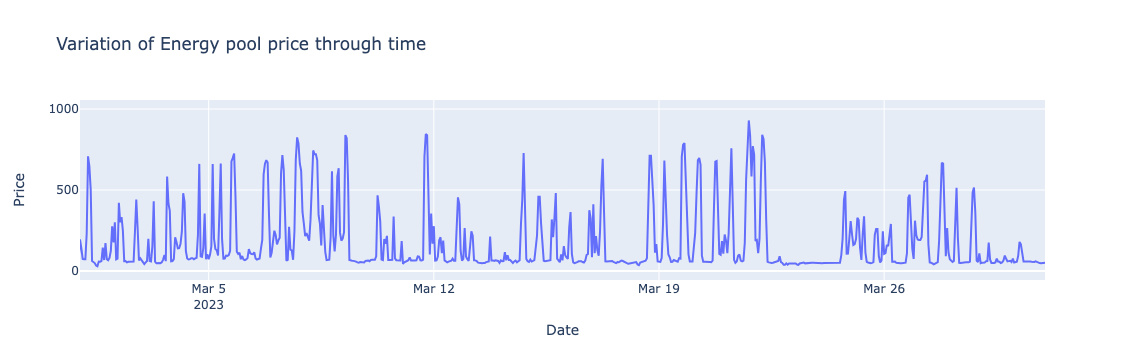

In [63]:
# Create an interactive plot for the target variable
fig = go.Figure()

trace = go.Scatter(x=df.index, y=df['price'], name='Price', mode='lines')
fig.add_trace(trace)

# Set x-axis range to focus on March 2023
fig.update_layout(title="Variation of Energy pool price through time", xaxis_title="Date", yaxis_title="Price", xaxis_range=['2023-03-01', '2023-03-31'])

fig.show()


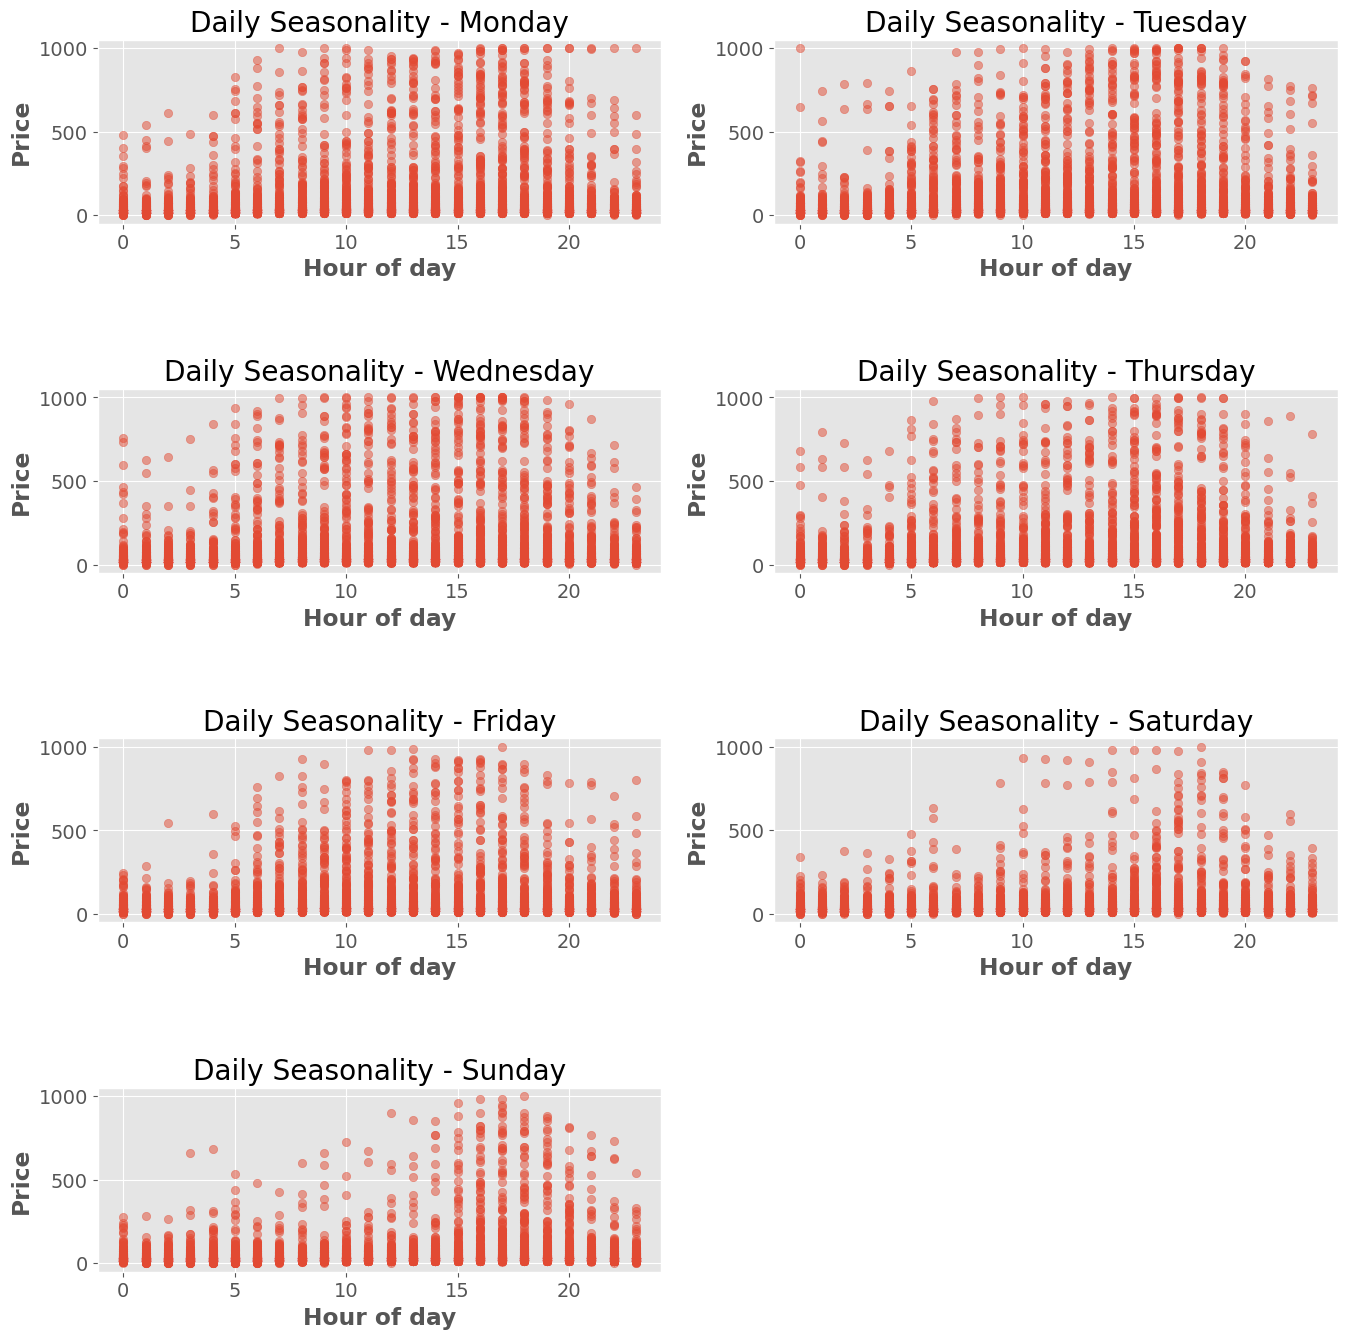

In [64]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
plt.subplots_adjust(hspace=0.9)

# Loop through days of the week and plot data
for i, ax in enumerate(axs.flat):
    if i > 6:
        break

    day = df[df.index.dayofweek == i]
    ax.scatter(day.index.hour, day['price'], alpha=0.5)
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Price')
    ax.set_title(f'Daily Seasonality - {day.index[0].strftime("%A")}')

# Remove empty subplots
plt.delaxes(axs[3][1])

plt.show()


<Figure size 1000x800 with 0 Axes>

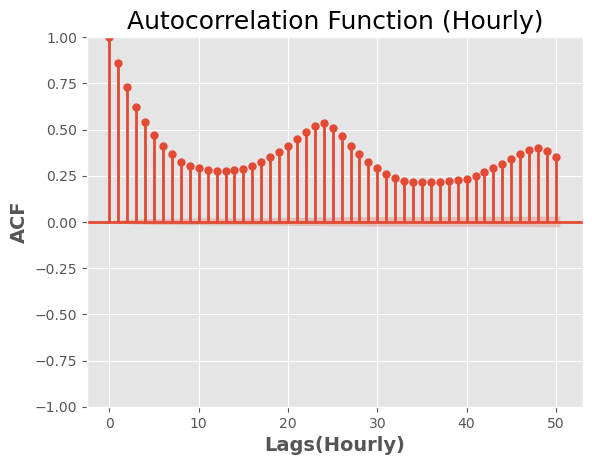

In [65]:
fig = plt.figure(figsize=(10, 8))

# ACF plot
plot_acf(df['price'], lags=50)
plt.title('Autocorrelation Function (Hourly)', fontsize=18)
plt.xlabel('Lags(Hourly)', fontsize=14)
plt.ylabel('ACF', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.show()

Text(0.5, 0, 'Lag (daily)')

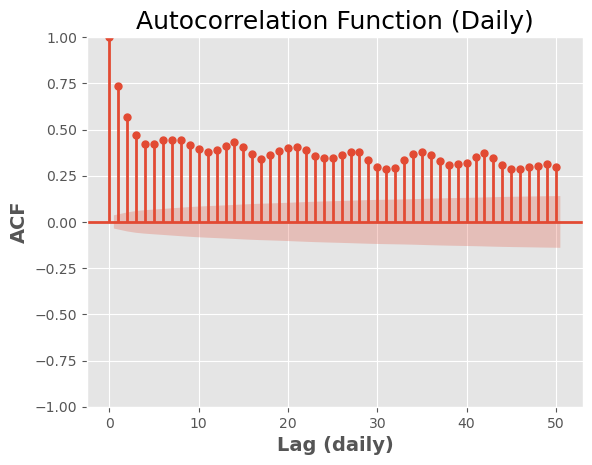

In [66]:
fig = plot_acf(df["price"].resample("D").mean(), lags=50, title=None, bartlett_confint=True)
plt.xlabel('Lags', fontsize=14)
plt.ylabel('ACF', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title('Autocorrelation Function (Daily)', fontsize=18)
plt.ylabel("ACF")
plt.xlabel("Lag (daily)")

## Timeline
The project timeline is designed to ensure timely delivery. The first two weeks are allocated for proposal preparation, problem and data understanding, and initial EDA analysis. The primary workload will be during the four middle weeks, where focus will be on extended EDA analyses, feature engineering, model design and evaluation, data visualization, and dashboard development. Week 7 is reserved for product deployment, model refinement, bug fixing, and report finalization. Finally, week 8 is for wraping up, creating presentation and ensuring readiness for implementation by targeted audiences.
![Timeline](timeline.png)